## Introduction
This tutorial will introduce you to recommender systems. Recommender systems has become very common in our daily lives now and has been widely used in different areas. Netflix, Amazon, Facebook and many other websites or applications have applied recommender systems to better predict users' preference based on the users' past behaviors. There are different approches to build recommender systems: Collaborative Filtering, Content-based, Personalized Learning to Rank, Demographic, Social recommendations and Hybrid. Collaborative Filtering is the most popular one. This tutorial will focus on this method.

### Tutorial content
In this tutorial, I will show you how to build a simple recommender system in Python. We will be using the dataset MovieLens (http://grouplens.org/datasets/movielens/100k/). It contains 100,000 ratings (1-5) from 1000 users on 1700 movies.

We will cover the following topics in this tutorial:
- [Loading Data](#Loading-data)
- [Collaborative Filtering](#Collaborative-Filtering)
- [Predicting](#Predicting)
- [Test and Evaluation](#Test-and-Evaluation)
- [Summary and references](#Summary-and-references)

## Loading data

In [29]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

matplotlib.rc("figure", figsize=(8,6))
matplotlib.rc("axes", labelsize=16, titlesize=16)
matplotlib.rc("xtick", labelsize=14)
matplotlib.rc("ytick", labelsize=14)
matplotlib.rc("legend", fontsize=14)
matplotlib.rc("font", size=14)

Let's load the MovieLens dataset. Download the data from http://grouplens.org/datasets/movielens/100k/. Then unzip the `ml-100k.zip` file to create a folder. The `README` file has a detailed description of the data. Basically the `u.data` is the full rating dataset. It is a tab-separated list of user id, item id, rating and timestamp. The user id and item id are both consecutive numbers starting from 1. The `u.item` file contains a bunch of information including the movie's id, name, the movie's genre etc. We only extract the movies' name from this file.

In [2]:
# import rating data
cols = ['user_id', 'item_id', 'rating', 'timestamp']
df_rating = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=cols)
# import movie name
# we can obtain the mapping between movie name and id through the index of df_movie
df_movie = pd.read_csv('ml-100k/u.item', sep='|', header=None, usecols=[1])
df_movie.columns = ['movie_name']

In [3]:
df_rating.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
df_movie.head()

,movie_name
0,Toy Story (1995)
1,GoldenEye (1995)
2,Four Rooms (1995)
3,Get Shorty (1995)
4,Copycat (1995)


The index for the `df_movie` dataframe is the same as the `item id` in `df_rating`. 

In [5]:
df_rating.shape

(100000, 4)

There are 100,000 ratings in this dataframe. Next we will explore the dataset a little bit. Firstly, let us check the top 10 most rated movies by users.

In [6]:
# top 10 most rated movies by users
df_merge = df_rating.merge(df_movie, how="inner", left_on="item_id", right_index=True)
print df_merge.head()
# get the rated counts for each movie
top_movies = pd.value_counts(df_merge.movie_name)
# print the top 10
top_movies.head(10)

      user_id  item_id  rating  timestamp            movie_name
0         196      242       3  881250949  Jungle2Jungle (1997)
253        63      242       3  875747190  Jungle2Jungle (1997)
629       226      242       5  883888671  Jungle2Jungle (1997)
1232      154      242       3  879138235  Jungle2Jungle (1997)
2159      306      242       5  876503793  Jungle2Jungle (1997)


Legends of the Fall (1994)     583
George of the Jungle (1997)    509
Heavy Metal (1981)             508
GoodFellas (1990)              507
Breakdown (1997)               485
Marvin's Room (1996)           481
Evita (1996)                   478
GoldenEye (1995)               452
Desperate Measures (1998)      432
In & Out (1997)                431
Name: movie_name, dtype: int64

Next, let us check the distribution of ratings.

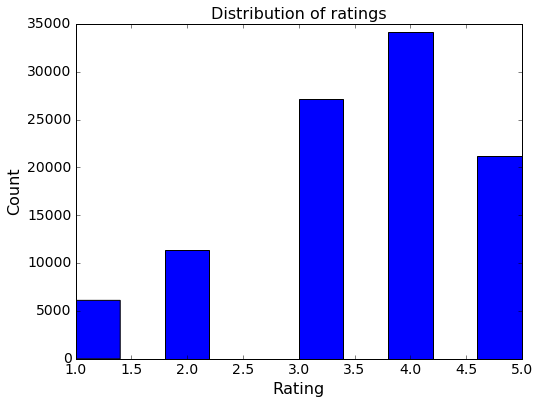

In [7]:
# Distribution of ratings
plt.hist(df_rating['rating'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title('Distribution of ratings')

Next, let us check the mean and median of ratings.

In [8]:
# mean and standard deviation of ratings
print np.mean(df_rating['rating'])
print np.std(df_rating['rating'])

3.52986
1.12566797076


On a scale range from 1.0 to 5.0, the average rating is 3.52. The standard deviation is 1.12.

Now we can build the user/movie rating matrix. Since the user id and movie id both start from 1, we need to do an offset by 1 process to make the id start from 0. Thus we can easily map id to indice. Every row in this matrix represents a user's rating vector for movies. A zero rating in the rating cell indicates an empty rating.

In [30]:
def user_movie_matrix(df_rating):
    """ 
    Input:
        df_rating (pandas dataframe) : users' ratings
    Output:
        M (matrix) : user/movie rating matrix
    """
    #get number of users
    max_user_id = np.max(df_rating['user_id'])
    print 'Total user number %s' % max_user_id
    #get number of movies
    max_movie_id = np.max(df_rating['item_id'])
    print 'Total movie number %s' % max_movie_id
    # construct user/movie matrix
    M = np.zeros((max_user_id, max_movie_id))
    # user id and movie id subtract by 1
    for row in df_rating.iterrows():
        M[row[1][0] - 1, row[1][1] - 1] = row[1][2]
    return M

In [35]:
M = user_movie_matrix(df_rating)
# print the top 10 rows and cols of matrix
print M[:10,:10]

Total user number 943
Total movie number 1682
[[ 5.  3.  4.  3.  3.  5.  4.  1.  5.  3.]
 [ 4.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4.  3.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.  2.  4.  4.  0.]
 [ 0.  0.  0.  5.  0.  0.  5.  5.  5.  4.]
 [ 0.  0.  0.  0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  5.  4.  0.  0.  0.]
 [ 4.  0.  0.  4.  0.  0.  4.  0.  4.  0.]]


Now we can plot the distribution of number of ratings per user.

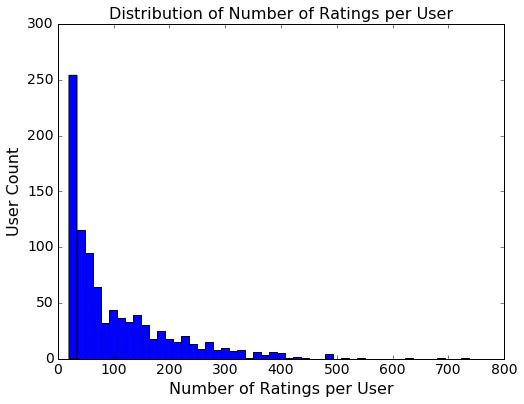

In [45]:
num_of_rating = pd.DataFrame(M).replace('0', np.nan).count(axis=1)
plt.hist(num_of_rating, bins=50);
plt.xlabel("Number of Ratings per User")
plt.ylabel("User Count")
plt.title('Distribution of Number of Ratings per User')

We can also plot the distribution of mean ratings for movies.

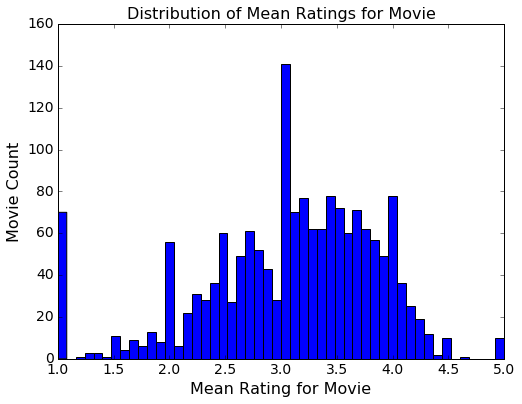

In [47]:
mean_rating = pd.DataFrame(M).replace('0', np.nan).mean(axis=0)
plt.hist(mean_rating, bins=50);
plt.xlabel("Mean Rating for Movie")
plt.ylabel("Movie Count")
plt.title('Distribution of Mean Ratings for Movie')

## Collaborative Filtering

The idea behind this is quite simple. People like you may possibly like what you like. For example, the task is to recommend a movie to you. The recommender systems will search other users to find a person that is similar to you in the movies he likes. Once the person is found, the recommender system can recommend the person's favorite movies to you. Now the question becomes how do recommender systems know who are similar to each other. There are different ways to do so. Usually the recommender system will look at the distance or correlation between two vectors that represent users' preferences. Manhattan distance, Euclidean distance, Pearson correalation and Cosine similarity are all good methods. For this tutorial, we only implement cosine similarity. If you are interested, you can try different methods to test whether it affects the recommender model's quality.
`Cosine similarity` is a measure of similarity between two vectors that measures the cosine of the angle between them.
Now, we use the following function to compute the Cosine Similarity between users' preferences.

In [11]:
def cosine_similarity(v1, v2):
    """ 
    Input:
        v1 (np.array) : array representing user1's ratings
        v2 (np.array) : array representing user2's ratings
    Output:
        (double) : cosine similarity between user1 and user2
    """
    n1 = np.sqrt(v1.dot(v1))
    n2 = np.sqrt(v2.dot(v2))
    return v1.dot(v2) / (n1 * n2)

For example, we can compute the consine similarity between user1 and user2.

In [12]:
v1 = M[0,:]
v2 = M[1,:]
cosine_similarity(v1, v2)

0.16693098386870195

Now we can build the similarity matrix. A cell [i,j] in this matrix represents the similarity between user i and user j.

In [13]:
# compute similarities using for loops
def build_similarity_matrix(rating):
    """ 
    Input:
        rating (matrix) : each row represents users' preferences
    Output:
        similarity (matrix) : cosine similarity matrix
    """
    similarity = np.zeros((rating.shape[0], rating.shape[0]))

    for i in range(0, rating.shape[0]):
        for j in range(0, rating.shape[0]):
            similarity[i, j] = cosine_similarity(rating[i,:], rating[j, :])
    return similarity

In [14]:
%timeit build_similarity_matrix(M)

1 loop, best of 3: 10.3 s per loop


From the above example, we can see that the function to build the similarity matrix using for loops is very slow. A better way to construct similarity matrix is to use matrix operations instead of for loops. We can firstly normalize each row and them multiply the mormalized rating matrix by its transpose matrix.

In [15]:
# build similarity matrix using matrix operations
def similarity_matrix(rating):
    """ 
    Input:
        rating (matrix) : each row represents users' preferences
    Output:
        similarity (matrix) : cosine similarity matrix
    """
    # compute norm for each row
    norm = np.linalg.norm(rating, axis=1)
    # normalize each row
    rating = rating / norm[:,None]
    similarity = rating.dot(rating.T)
    return similarity

In [21]:
%timeit similarity_matrix(M)

10 loops, best of 3: 54.9 ms per loop


In [20]:
sim=similarity_matrix(M)
sim

array([[ 1.        ,  0.16693098,  0.04745954, ...,  0.14861694,
         0.17950788,  0.39817474],
       [ 0.16693098,  1.        ,  0.11059132, ...,  0.16148478,
         0.17226781,  0.10579788],
       [ 0.04745954,  0.11059132,  1.        , ...,  0.10124256,
         0.13341615,  0.02655587],
       ..., 
       [ 0.14861694,  0.16148478,  0.10124256, ...,  1.        ,
         0.1016418 ,  0.09511958],
       [ 0.17950788,  0.17226781,  0.13341615, ...,  0.1016418 ,
         1.        ,  0.18246466],
       [ 0.39817474,  0.10579788,  0.02655587, ...,  0.09511958,
         0.18246466,  1.        ]])

We can see that using matrix operations is much faster compared to computing cells in matrix one by one.

## Predicting

Now with our similarity matrix, we can predict ratings. To predict a user `u`'s rating for a movie `m`, we need to sum the weighted ratings of all the other users for the movie `m`. The weight is the cosine similarity between user `u` and all the other users. Then we also need to normalize the sum by the sum of weights to get the prediction.

In [22]:
# predict rating for users
def predict(rating, similarity):
    """ 
    Input:
        rating (matrix) : each row represents users' preferences
        similarity (matrix) : cosine similarity matrix
    Output:
        prediction (matrix) : prediction of users' ratings
    """
    prediction = np.zeros(rating.shape)
    # compute prediction for each movie
    for i in range(0, rating.shape[0]):
        for j in range(0, rating.shape[1]):
            # compute weighted sum
            weighted_sum = similarity[i, :].dot(rating[:, j])
            # normalize by sum of weights
            prediction[i, j] = weighted_sum / np.sum(np.abs(similarity[i, :]))
    return prediction

In [23]:
%timeit predict(M, sim)

1 loop, best of 3: 39.9 s per loop


As a previous example shows, funcions using for loops take more time than using matrix operations. Thus we can use matrix operations to implement the above predict function.

In [26]:
# using matrix operations
def predict_fast(rating, similarity):
    """ 
    Input:
        rating (matrix) : each row represents users' preferences
        similarity (matrix) : cosine similarity matrix
    Output:
        prediction (matrix) : prediction of users' ratings
    """
    # compute weighted sum
    weighted_sum = similarity.dot(rating)
    # normalize by sum of weights
    return weighted_sum / np.array([np.abs(similarity).sum(axis=1)]).T

In [27]:
%timeit predict_fast(M, sim)

10 loops, best of 3: 83 ms per loop


In [28]:
prediction= predict_fast(M, sim)
prediction

array([[  2.42492083e+00,   7.58241451e-01,   4.44433098e-01, ...,
          5.37552717e-04,   6.51021154e-03,   7.36117851e-03],
       [  1.88253580e+00,   3.25506086e-01,   3.02482424e-01, ...,
          3.36814306e-03,   2.77008816e-03,   1.91219324e-03],
       [  1.32849217e+00,   2.90918284e-01,   2.36176026e-01, ...,
          8.35623444e-03,   2.61921448e-03,   1.18219930e-03],
       ..., 
       [  2.45321901e+00,   4.48412395e-01,   3.96938958e-01, ...,
          1.22401650e-03,   4.00566986e-03,   3.02918177e-03],
       [  2.03994198e+00,   5.87603968e-01,   3.03290502e-01, ...,
          2.08310984e-03,   5.33460874e-03,   3.31510554e-03],
       [  2.51325405e+00,   8.82071088e-01,   4.83121150e-01, ...,
          0.00000000e+00,   7.53072560e-03,   7.06815298e-03]])

In this section, we use all the other users' ratings in our prediction process. However, we can use a subset of the other users' ratings. For example, the top k most similar users. There are also other methods, such as considering the relative difference in ratings rather than using absolute ratings since there may exists some users who always tend to give high ratings or low ratings. If you are interested, you can try different methods to test the quality of the model. 

## Test and Evaluation

The movieLens dataset contains `ua.base`, `ua.test`, `ub.base`, and `ub.test` which split user data into training set and test set with exactly 10 ratings per user in the test set. `ua.test` and `ub.test` are disjoint. We can predict based on the training set and then compare the predictions with test set to validate the quality of our recommender model. We use the scikit-learn's mean squared error function as our validation method.

Firstly, we need to read dataset from file to pandas dataframe.

In [33]:
#read dataset
df_train_a = pd.read_csv('ml-100k/ua.base', sep='\t', header=None, names=cols)
df_test_a = pd.read_csv('ml-100k/ua.test', sep='\t', header=None, names=cols)
df_train_b = pd.read_csv('ml-100k/ub.base', sep='\t', header=None, names=cols)
df_test_b = pd.read_csv('ml-100k/ub.test', sep='\t', header=None, names=cols)

Next, we will construct user/movie matrix.

In [34]:
#construct user/movie matrix
train_a_M = user_movie_matrix(df_train_a)
test_a_M = user_movie_matrix(df_test_a)
train_b_M = user_movie_matrix(df_train_b)
test_b_M = user_movie_matrix(df_test_b)

Total user number 943
Total movie number 1682
Total user number 943
Total movie number 1664
Total user number 943
Total movie number 1682
Total user number 943
Total movie number 1661


Next, we will construct similarity matrix based on training data.

In [36]:
# construct similarity matrix
sim_a = similarity_matrix(train_a_M)
sim_b = similarity_matrix(train_b_M)

Next, we will make predictions.

In [38]:
# precition
prediction_a = predict_fast(train_a_M, sim_a)
prediction_b = predict_fast(train_b_M, sim_b)

Now let us implement our metric function to validate the quality of this recommender model.

In [39]:
# compute validation metric
def compute_mse(prediction, real):
    """ 
    Input:
        prediction (matrix) : prediction of users' ratings
        real (matrix) : real user ratings
    Output:
        mse (double) : mean squared error
    """
    # rule out the empty rating
    prediction = prediction[real.nonzero()].flatten()
    real = real[real.nonzero()].flatten()
    return mean_squared_error(prediction, real)

In [41]:
print 'MSE for dataset a: ' + str(compute_mse(prediction_a, test_a_M))
print 'MSE for dataset b: ' + str(compute_mse(prediction_b, test_b_M))

MSE for dataset a: 8.41892604543
MSE for dataset b: 8.46174692632


## Summary and references

This tutorial highlighted just a few elements about how to build a simple recommender system in Python.  Much more detail about the recommender systems and questions on the MovieLens dataset are available from the following links.

1. Recommender Systems Handbook: http://www.cs.ubbcluj.ro/~gabis/DocDiplome/SistemeDeRecomandare/Recommender_systems_handbook.pdf 
2. MovieLens: http://grouplens.org/datasets/movielens/
3. Coursera course: https://www.coursera.org/specializations/recommender-systems